<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/notebooks/jax_md_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
#@title Imports & Utils
!pip install -q git+https://www.github.com/google/jax-md

import time 

from functools import partial
import numpy as onp

import jax.numpy as np

from jax import jit
from jax import grad
from jax import vmap
from jax import value_and_grad

from jax import random
from jax import lax

from jax.experimental import stax
from jax.experimental import optimizers

from jax.config import config
config.update('jax_enable_x64', True)

# NOTE(schsam): We need this in OSS I think.
from IPython.display import HTML, display
import time

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

f32 = np.float32
f64 = np.float64

def draw_system(R, box_size, marker_size, color=None):
  if color == None:
    color = [64 / 256] * 3
  ms = marker_size / box_size

  R = onp.array(R)

  marker_style = dict(
      linestyle='none', 
      markeredgewidth=3,
      marker='o', 
      markersize=ms, 
      color=color, 
      fillstyle='none')

  plt.plot(R[:, 0], R[:, 1], **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.axis('off')

def square_lattice(N, box_size):
  Nx = int(np.sqrt(N))
  Ny, ragged = divmod(N, Nx)
  if Ny != Nx or ragged:
    assert ValueError('Particle count should be a square. Found {}.'.format(N))
  length_scale = box_size / Nx
  R = []
  for i in range(Nx):
    for j in range(Ny):
      R.append([i * length_scale, j * length_scale])
  return np.array(R)

     |████████████████████████████████| 342 kB 37.2 MB/s 
     |████████████████████████████████| 90 kB 10.3 MB/s 


/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


# JAX, M.D.

## End-to-End Differentiable, Hardware Accelerated, Molecular Dynamics in Pure Python

In this notebook, we explore the features of JAX, M.D. through several experiments.
1. A simple simulation of packed bubbles.
4. Efficient generation of ensembles of systems.
2. Using neural networks to learn an energy function.
5. Meta-optimization through simulation to identify physical parameters that lead to frustration.

While these examples are designed to be illustrative, they are similar to problems faced in actual research. Aside from the first case, each of these examples would be arduous using existing tools. 


## Warmup: Simulating a Bubble Raft

We begin with a lightning introduction to molecular dynamics simulations. As an example, we're going to imagine some bubbles floating on water so that they live on a two-dimensional interface between water and air. It turns out, when the density of bubbles is high enough, they spontaneously crystalize. Here's an example of a real experiment from [Wikipedia](https://en.wikipedia.org/wiki/Bubble_raft):

![alt text](https://upload.wikimedia.org/wikipedia/commons/8/89/Bubblerraft2.jpg)

Looking at the picture, we see that the bubbles end up lying on the vertices of hexagons, but why is this? We're going to try to get some answers to this question by making a model that we can simulate. In particular, we're going to try to ask what happens if we have a bubble raft where the bubbles are on corners of squares instead of hexagons. Will they stay in a square configuration or end up back in a hexagonal one?

We'll describe $N$ bubbles by positions, $\{\vec r_i\}_{1\leq i \leq N}$. Since the bubbles are confined to the water's surface, the positions can be 2-dimensional vectors, $\vec r_i\in\mathbb R^2$. For simplicity, we'll assume that the bubbles have a radius of $1$. Let's create some bubbles by assigning them to be at the vertices of a square.

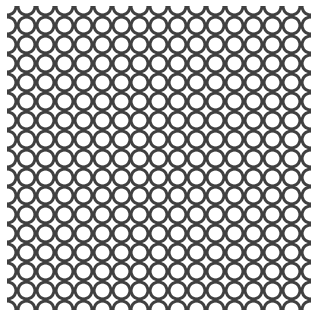

In [2]:
from jax_md import quantity

N = 256
box_size = quantity.box_size_at_number_density(particle_count=N, 
                                               number_density=1, 
                                               spatial_dimension=2)

r = square_lattice(N, box_size)
draw_system(r, box_size, 270.0)
finalize_plot((0.75, 0.75))

The positions, `r`, is just a numpy array and so we can shift the particles simply by adding a vector to `r`.

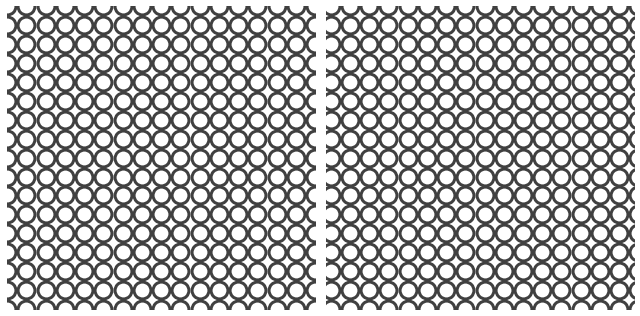

In [3]:
r_new = r + np.array([[0.25, 0]])

plt.subplot(1, 2, 1)
draw_system(r, box_size, 270.0)

plt.subplot(1, 2, 2)
draw_system(r_new, box_size, 270.0)

finalize_plot((1.5, 0.75))

Here, we are simulating a relatively small bubble raft. We can emulate a much larger bubble raft by combining our small simulation with periodic boundary conditions. Periodic boundary conditions are very common and they allow bubbles to wrap around the edges of the box like in the game "Asteroids". In JAX MD, we construct periodic boundary conditions using the function `space.periodic(box_size)` which returns a tuple of two functions, `(displacement_fn, shift_fn)`. The functions in the tuple do the following,

*   `dr_ij = displacement_fn(r_i, r_j)` takes a pair of positions and computes the displacement between them.
*   `r_p = shift_fn(r, delta_r)` takes a position and a shift and returns a new shifted position.

In [4]:
from jax_md import space

displacement_fn, shift_fn = space.periodic(box_size)

Next we need to posit interactions between our bubbles that simulate real bubbles. We'll assume that we can model a pair of bubbles by defining an energy function for the pair. We can use an energy that is zero if the bubbles aren't touching and then increases gradually as they get pushed together. Specifically, if $r_{ij}$ is the distance between bubble $i$ and $j$, we'll try out a function that looks like:

$$
U(r_{ij}) = \begin{cases}
  (1 - r_{ij})^2 & \text{if $r_{ij} < 1$} \\ 
  0 & \text{if $r_{ij}>1$}
  \end{cases}
$$  
When we run our simulation, by having bubbles move to try to minimize the energy between them they will naturally separate if they overlap.

This is implemented in JAX MD using the function `energy.soft_sphere(r)` which takes a distance and returns an energy.

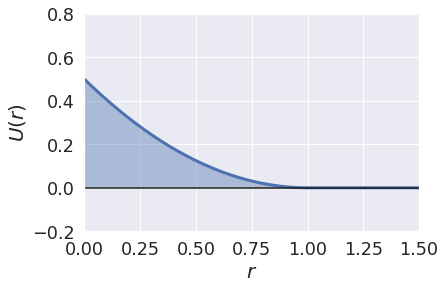

In [5]:
from jax_md import energy

dr = np.linspace(0, 3.0, num=80)
plt.plot(dr, energy.soft_sphere(dr), 'b-', linewidth=3)
plt.fill_between(dr, energy.soft_sphere(dr), alpha=0.4)

plt.gca().axhline(y=0, color='k')
plt.xlim([0, 1.5])
plt.ylim([-0.2, 0.8])

format_plot('$r$', '$U(r)$')

Once we've assigned an energy, $U(r_{ij})$, to pairs of bubbles, we have to assign an energy to to the whole system, $\mathcal U$. As we will see, our simulation will make use of the forces, $\vec F_i = -\nabla_{\vec r_i}\mathcal U$. This is usually done by just summing up all the pairwise energies,
$$\mathcal U = \frac12\sum_{ij}U(r_{ij}).$$
To compute the energy of the whole bubble raft in JAX, M.D. we use the helper function `energy_fn = energy.soft_sphere_pair(displacement_fn)` which returns a function that computes the soft-sphere energy for our bubble raft in its periodic box.

In [6]:
energy_fn = energy.soft_sphere_pair(displacement_fn)
print('Energy of the system, U = {:f}'.format(energy_fn(r)))

Energy of the system, U = 0.000000


We can now run an actual simulation our bubbles. We're going to use a simulation called [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion). Brownian motion are described by a first-order differential equation relating the velocity of bubbles to the forces on them along with random kicks coming from the water,
$$\frac{d{\vec r}_i(t)}{dt} = \vec F_i(t) + \sqrt{2k_BT}\vec \xi_i(t).$$
Here $\vec F_i(t)$ are forces, $\vec \xi_i\sim\mathcal N(0, 1)$ is i.i.d. Gaussian distributed noise, and $k_BT$ specifies the temperature of the water. Incidentally, this model of objects in water [dates back to Einstein.](http://users.physik.fu-berlin.de/~kleinert/files/eins_brownian.pdf)

To simulate brownian motion we will need to draw the $\xi_i$ from a Gaussian distribution. In [JAX, random numbers](https://en.wikipedia.org/wiki/Brownian_motion) do not use global state. Instead we have to instantiate the state of random numbers explicitly using `random.PRNGKey(seed)`. 



In [7]:
key = random.PRNGKey(0)

Simulations in JAX, MD are modeled after [JAX optimizers.](https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html?highlight=optimizers) To run a Brownian motion simulation we use the function `simulate.brownian(energy_fun, shift_fun, dt, temperature)` where `dt` is the time-step of the simulation and `temperature` is the simulated temperature; `simulate.brownian` return a pair of functions, `(init_fn, apply_fn)` which have the following properties,

*   `state = init_fn(key, r)` take the state of a random number generator and bubble positions. It returns a simulation state that might contain auxiliary information.
*   `state = apply_fn(state)` which increments the simulation by a step.

We can now setup some experimental parameters and create a simulation.
 

In [8]:
from jax_md import simulate

simulation_steps = 20000
write_every = 100
dt = 1e-1
temperature = 1e-5

init_fn, apply_fn = simulate.brownian(energy_fn, shift_fn, dt, temperature)

Normal execution in JAX executes each line as a separate call to the GPU. However, it can be significantly faster to compile entire functions into single device calls. To do this we use JAX's [just-in-time compilation](https://github.com/google/jax#compilation-with-jit), `jit`, to compile functions to XLA [XLA](https://www.tensorflow.org/xla)  which then get optimized and run as single device calls. The function `compiled_fun = jit(fun)` takes a function and returns a new compiled version of the function.

In [9]:
apply_fn = jit(apply_fn)

Now we can run the simulation. We will record the positions of the simulation every so often to visualize it later.

In [10]:
state = init_fn(key, r)
trajectory = []

for step in ProgressIter(range(simulation_steps)):
  state = apply_fn(state)
  if step % write_every == 0:
    trajectory += [state.position]

trajectory = np.stack(trajectory)

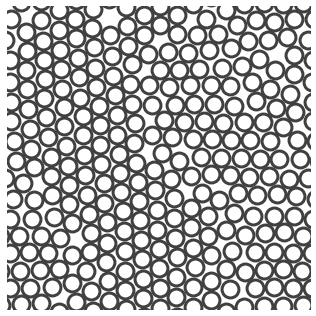

In [11]:
draw_system(state.position, box_size, 270.0)
finalize_plot((0.75, 0.75))

We see that our bubble raft has changed in structure from a square configuration to a hexagonal one spontaneously! Note, however, that in both cases the energy of the raft is zero. Therefore, the hexagonal configuration is **not** a lower energy state than the square one. This is reminiscient of recent findings in deep learning where different models can achieve perfect training loss with very different test losses. In this case it turns out the hexagonal configuration is favored only when noise is added to the dynamics. We say that the hexagonal configuration is favored *entropically*.

We can render the simulation trajectory using the `colab_tools.renderer` convenience functions.

In [12]:
from jax_md.colab_tools import renderer

renderer.render(
    box_size,
    {'particles': renderer.Disk(trajectory)},
    resolution=(512, 512)
)

## Automatic Ensembling

Improvements to processing power are increasingly due to device parallelism rather compute speed. This parallelism is often used to simulate increasingly large systems. However, there are other interesting uses of parallelism that have recieved less attention. Many of these methods (e.g. [replica exchange MCMC sampling](https://en.wikipedia.org/wiki/Parallel_tempering)) involve simulating an entire ensemble of states simultaneously. 

Thanks to JAX, ensembling can be done automatically in JAX MD. For small systems, the amount of necessary compute can be sub-linear in the number of replicas since it can otherwise be difficult to saturate the parallelism of accelerators. Here we go through an example where we use automatic ensembling to quickly compute statistics of a simulation.

We will set up a function that takes a random key and a temperature. The function will use the key to initialize a bubble raft (see the warmup) and simulate it for some time at the given temperature. We will then return the positions of the bubbles. To begin with, however, we will define some aspects of the simulation that will stay fixed across members of the ensemble. 

In [13]:
N = 32
dt = 1e-1
simulation_steps = np.arange(1000)
key = random.PRNGKey(0)

box_size = quantity.box_size_at_number_density(particle_count=N, 
                                               number_density=1,
                                               spatial_dimension=2)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement)

Now we define the actual simulation. To do this, we use a  [JAX function](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html?highlight=scan) called `lax.scan` which is effectively a differentiable for-loop that is executed in a single operation on-device.

In [14]:
def simulation(key, temperature):
  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
  state = init_fn(sim_key, R)

  do_step = lambda state, t: (apply_fn(state, t=t), t)
  state, _ = lax.scan(do_step, state, simulation_steps)

  return state.position

We can run a single copy of the simulation by calling `run_simulation`. We see that `run_simulation` returns positions with shape `(bubble_count, spatial_dimension)`.

bubble_positions.shape = (32, 2)


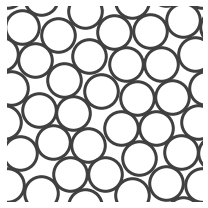

In [15]:
bubble_positions = simulation(key, temperature=1e-5)
print('bubble_positions.shape = {}'.format(bubble_positions.shape))
draw_system(bubble_positions, box_size, 190)
finalize_plot((0.5, 0.5))

However, this is a small system and we are clearly not using all of the compute in our GPU efficiently. To run an ensemble of simulations at once we use [the JAX function](https://github.com/google/jax#auto-vectorization-with-vmap) `vmap`. Given a function, `f`, `vectorized_f = vmap(f, in_axes, out_axis)` creates a new function with the same behavior as `f` except that it is vectorized over many inputs simultaneously. Specification of which inputs to vectorize is provided by `in_axes`.

Here is an example using `vmap` to vectorize our simulation over many different random keys simultaneously. Note that here `in_axes=(0, None)` to indicate that we want to vectorize over axis 0 of the random keys but we do not want to vectorize over the temeprature.

In [16]:
# We only want to vectorize over the keys which we denote by in_axis=(0, None).
vectorized_simulation = vmap(simulation, in_axes=(0, None))

Now we can run and draw an ensemble of 9 simulations simultaneously. We see now that `bubble_positions` has shape `(ensemble_size, bubble_count, spatial_dimension)`.

bubble_positions.shape = (9, 32, 2)


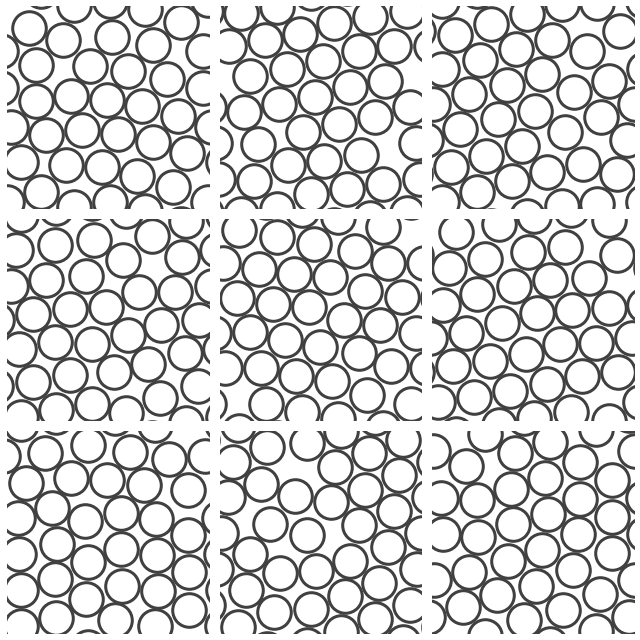

In [17]:
ensemble_size = 9
simulation_keys = random.split(key, ensemble_size)

bubble_positions = vectorized_simulation(simulation_keys, 1e-5)
print('bubble_positions.shape = {}'.format(bubble_positions.shape))

for i in range(9):
  plt.subplot(3, 3, i + 1)
  draw_system(bubble_positions[i], box_size, 190)

finalize_plot((1.5, 1.5))

We can use this to look at a distribution over the energies of bubble raft configurations by increasing the size of the ensemble significantly.

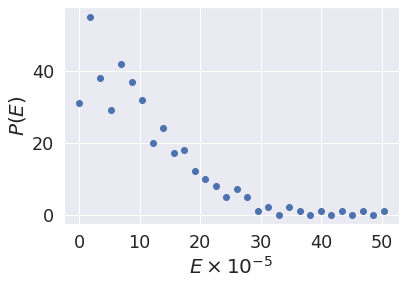

In [18]:
ensemble_size = 400
simulation_keys = random.split(key, ensemble_size)

vectorized_energy = vmap(energy_fn)

bubble_positions = vectorized_simulation(simulation_keys, 1e-5)
bubble_energies = vectorized_energy(bubble_positions)

counts, bins = onp.histogram(bubble_energies, bins=30)
plt.plot(bins[:-1] * 10 ** 5, counts, 'o')
format_plot('$E\\times 10 ^{-5}$', '$P(E)$')

So far we have vectorized the simulation over only the random key. Another experiment that we can run is to vectorize separately over the key and the temperature. In this way we can run an experiment where we look at how the distribution of energies changes with temperature using a single call to the simulation. We use this to plot the mean and variance of energy as a function of temperature. 

In [19]:
double_vectorized_simulation = vmap(vectorized_simulation, in_axes=(None, 0))

double_vectorized_energy = vmap(vectorized_energy)


ensemble_size = 20
simulation_keys = random.split(key, ensemble_size)
temperatures = 10 ** np.linspace(-5, -2, 10)

bubble_positions = double_vectorized_simulation(simulation_keys, temperatures)
bubble_energies = double_vectorized_energy(bubble_positions)

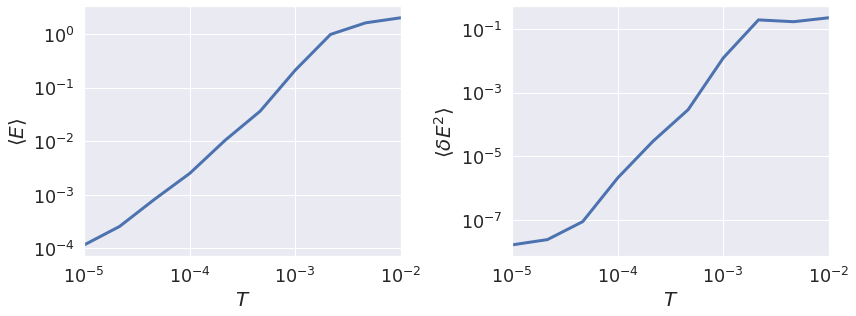

In [20]:
plt.subplot(1, 2, 1)

plt.loglog(temperatures, np.mean(bubble_energies, axis=1), linewidth=3)
format_plot('$T$', '$\\langle E\\rangle$')

plt.xlim([10 ** -5, 10 ** -2])

plt.subplot(1, 2, 2)

plt.loglog(temperatures, np.var(bubble_energies, axis=1), linewidth=3)
format_plot('$T$', '$\\langle \\delta E^2\\rangle$')

plt.xlim([10 ** -5, 10 ** -2])

finalize_plot((2, 0.75))

We see that the average energy of the bubble rafts and the scale of fluctuations about the mean both increase as a powerlaw with temperature.

A final experiment that we can perform is to measure the time-per-simulation as a function of the number of simulations being vectorized over. We measure this below and plot the result. Because we're trying to get accurate timings for the scaling, this cell can take some time to run. 

In [21]:
dts = []
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
n_batches = 2

for batch_size in ProgressIter(batch_sizes):
  simulation_keys = random.split(key, batch_size)

  vectorized_simulation(simulation_keys, 1e-5)
  
  start = time.time()
  for i in range(n_batches):
    rs = vectorized_simulation(simulation_keys, 1e-5)
  rs.block_until_ready()
  dt = time.time() - start
  dts += [dt]

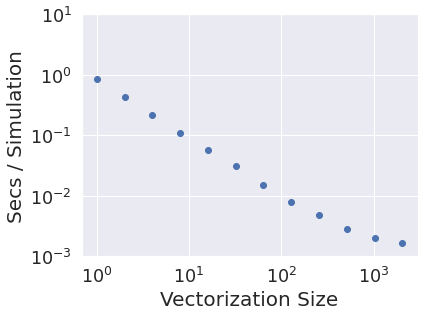

In [22]:
batch_sizes = np.array(batch_sizes)
dts = np.array(dts)

plt.loglog(batch_sizes, dts / batch_sizes / n_batches, 'o')

plt.ylim([10 ** -3, 10 ** 1])

format_plot('Vectorization Size', 'Secs / Simulation')
finalize_plot((1, 0.75))

As expected, we see that the time-per-simulation decreases with the number of simulations being performed in parallel. This scaling continues until the GPU becomes saturated. For a V100 GPU this happens at a batch size of about $2048$. 

## Machine Learned Potentials

In the examples so far, the accuracy of our simulation depends crucially on the energy function, $\mathcal U$, that we chose. As we saw above, historically, energy functions were often derived by hand based on coarse heuristics and few experimental results used as fitting parameters. More recently, energy functions with a larger number of fitting parameters (like [ReaxFF](https://en.wikipedia.org/wiki/ReaxFF)) have become popular due to their ability to accurately describe certain systems. However, these methods traditionally involve significant expert knowledge and fail for systems that deviate too much from those that they were designed for. A natural progression of this trend is to use neural networks and large datasets to learn energy functions. There were a number of early efforts that received mixed success. It was not until 2007 when Behler and Parrinello [published](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.98.146401) their general purpose neural network architecture that learned energy functions emerged as a viable alternative to traditional approaches. Since then large amounts of work has been done on this topic, however most of these developments have not seen as much use as might be expected. At the root of this discrepancy are several points of friction at the intersection of ML and MD that prevent rapid prototyping and deployment of learned energies:
1.   Simulation code and machine learning code are written in different languages.
2.   Due to the lack of automatic differentiation in molecular dynamics packages, including neural network potentials in physics simulations can require substantial work which often prohibits easy experimentation.

To address these issues, several projects developed adapters between common ML languages, like Torch and Tensorflow, and common MD languages like LAMMPS. However, these solutions require researchers to be working in exactly the regime serviced by the adapter. One of the consequences of this is that the atomistic features which get fed into the neural network need to be differentiated by hand within the MD package to compute forces. Trying out a new set of features can easily take weeks or months of work to compute and implement these derivatives. 

Here, as an example, we will fit a neural network to the bubble potential defined above. We will see that JAX MD gets around these issues easily. We will implement the Behler-Parrinello network in one line of pure python. We will then take gradients through the entire network and features in a single line of code. 

We will start out by creating a bubble raft using the code from the Automatic Ensembling example. We will then create a dataset of atomic configurations and their respective energies by adding Gaussian distortions atomic positions of a quenched system (as was done by Seko et al. [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.054113)).  

Below is the quenched system.


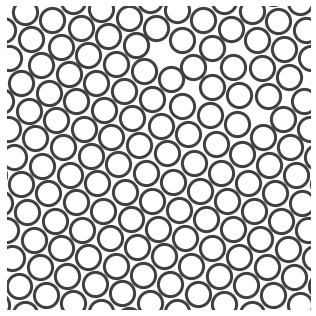

In [23]:
N = 128
dt = 1e-2
simulation_steps = np.arange(4000)
key = random.PRNGKey(0)

box_size = quantity.box_size_at_number_density(particle_count=N,
                                               number_density=1.2,
                                               spatial_dimension=2)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement)

bubble_positions = simulation(key, temperature=1e-5)

print('Below is the quenched system.')    
draw_system(bubble_positions, box_size, 250.0)
finalize_plot((0.75, 0.75))

Now that we have an example system, we can generate samples by adding Gaussian distortions to particle positions. Then we'll use `vmap` to evaluate their energies in an efficient, vectorized fashion. Finally, we'll plot the distribution of energies and one example distortion.

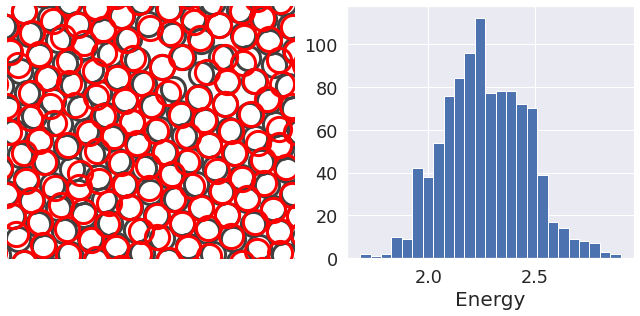

In [24]:
samples = 1000

key, distortion_key = random.split(key)
distortion = random.normal(distortion_key, (samples, N, 2)) * 0.1
distorted_positions = bubble_positions + distortion

energies = vmap(energy_fn)(distorted_positions)

plt.subplot(1, 2, 1)
draw_system(bubble_positions, box_size, 250.0)
draw_system(distorted_positions[0], box_size, 250.0, color=[1, 0, 0])

plt.subplot(1, 2, 2)
plt.hist(energies, bins=25)
plt.xlabel('Energy', fontsize=20)

finalize_plot((1.5, 0.75))

We now briefly describe the Behler-Parrinello architecture. For each bubble, one computes "features" which describe its local environment. The features for each bubble is fed into an identical copy of a fully-connected neural network. These per-bubble networks can be thought of as computing the energy of that particular bubble. The total energy, $\mathcal U$, is then a sum over the outputs of the per-bubble networks. 

While there are many different choices of features that achieve reasonable results here we use the ["radial symmetry function"](https://en.wikipedia.org/wiki/Radial_distribution_function), $g(r)$, to generate features for simplicity. The radial distribution function measures the density of neighbors a distance $r$ from a central bubble. By using a discrete set of radii, $\{r_i\}_{i\in M}$, we can generate a fixed feature set per-bubble. To do this we use the `pair_correlation` function included in JAX MD. `pair_correlation_fun = pair_correlation(displacement_fun)` creates a function that computes the pair correlation functions each bubble in a raft. We can then sum over the bubbles to compute the total pair correlation function. We create a `pair_correlation_fun` and use compute the pair correlation function for the bubble raft above as well as one of the gaussian distortions.

g(r) has shape (N, number of radii) = (128, 60).


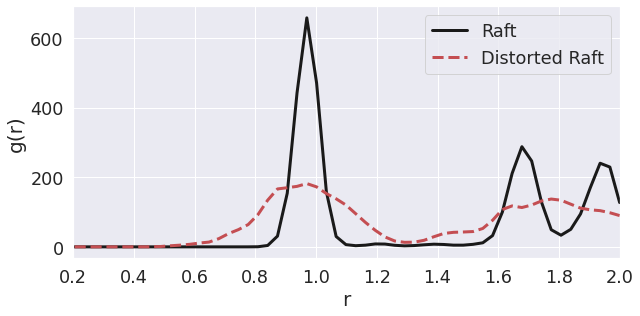

In [25]:
feature_rs = np.linspace(0.1, 2.0, 60)
g = quantity.pair_correlation(space.metric(displacement), feature_rs, 0.033)

pair_corr = g(bubble_positions)
print("g(r) has shape (N, number of radii) = {}.".format(pair_corr.shape))
plt.plot(feature_rs, np.sum(pair_corr, axis=0), 'k', linewidth=3)

plt.plot(
    feature_rs, np.sum(g(distorted_positions[0]), axis=0), 'r--', linewidth=3)

plt.xlabel('r', fontsize=20)
plt.ylabel('g(r)', fontsize=20)

plt.legend(['Raft', 'Distorted Raft'], loc='upper right')
plt.xlim([0.2, 2])

finalize_plot((1.5, 0.75))

Now we will split the dataset into a training set and test set. To make the calculation more efficient we will precompute the features. We note, however, that one could compute them online in an active learning setting.

In [26]:
no_training_samples = 800
print('Total number of examples is {}, number of\
 training examples is {}'.format(len(distorted_positions), no_training_samples))

vectorized_g = jit(vmap(g))

train_positions = np.array(distorted_positions[:no_training_samples])
train_features = vectorized_g(train_positions)
test_positions = np.array(distorted_positions[no_training_samples:])
test_features = vectorized_g(test_positions)

Total number of examples is 1000, number of training examples is 800


We now define the Behler-Parrinello neural network architecture. To do this we will use [JAX's neural network library](https://github.com/google/jax#neural-net-building-with-stax) called stax. Neural networks in stax defined using components, for example, fully connected layers or activation functions. Components are pairs of functions `(init_fun, apply_fun)`. 
1. `out_shape, params = init_fun(key, in_shape)` initializes the parameters of the component given a random key and an input shape.
2. `fxs = apply_fun(params, xs)` evaluates the component given parameters and inputs.

Stax then has combinator functions, `serial` and `parallel` that compose components new `(init_fun, apply_fun)` pairs. Although we will want to train our neural network using minibatching it is easier to define the Behler-Parrinello architecture on a single system and then use `vmap`.

In [27]:
no_hidden_units = 30
init_fun, _E = stax.serial(
    stax.Dense(no_hidden_units, ), stax.Relu,  # hidden layer 1
    stax.Dense(no_hidden_units), stax.Relu,  # hidden layer 2
    stax.Dense(1))  # readout
E = lambda params, features: _E(params, features)

We will now define a single-example MSE loss function and use `vmap` to generalize it to a batch of data. Note that the inputs to the network are not the positions directly, but the features computed from the positions.

In [28]:
def loss(params, positions, features):
  E_per_atom_per_system = E(params, features)
  E_total = np.sum(E_per_atom_per_system, axis=(1, 2))
  return np.mean((E_total - vmap(energy_fn)(positions))**2)
grad_loss = grad(loss)

Next, we are going to train our neural network with minibatches of 50 samples randomly picked from the training set. Note that we are calculating the label (energy) of a training example in the neural network training loop, which also allows us to simply convert our pipeline to an active learning pipeline.

To train our neural network, we will use JAX's optimizers. As with our simulation functions, optimizers return a triple e.g. `(opt_init, opt_update, get_params) = optimizers.adam(step_size)`. Here `state = opt_init(params)` initializes the optimizers state, `state = opt_update(step, dparams, state)` updates the state of the optimizer using gradients, and `params = opt_params(state)` gets parameters from an optimizer state.

In [29]:
key = random.PRNGKey(4)
train_steps = 3001
print_every = 250
batch_size = 50

training_samples = np.arange(no_training_samples)

# Initialize the network.
key, net_key = random.split(key)
_, params = init_fun(net_key, (-1, N, len(feature_rs)))

# Create the optimizer.
opt_init, opt_update, get_params = optimizers.adam(1e-2)
state = opt_init(params)

# Define and jit a single update step.
@jit
def update_step(state, batch):
  positions, features = batch
  params = get_params(state)
  d_params = grad_loss(params, positions, features)
  return opt_update(0, d_params, state)


def batch(key):
  steps_per_epoch = no_training_samples // batch_size 
  train_epochs = train_steps // steps_per_epoch
  for s in range(train_epochs):
    key, split = random.split(key)
    permutation = random.shuffle(split, training_samples)
    positions = train_positions[permutation]
    features = train_features[permutation]
    for i in range(0, no_training_samples, batch_size):
      batch_data = (positions[permutation[i:i + batch_size]], 
                    features[permutation[i:i + batch_size]])
      yield batch_data
  
# Precompute the test time energies.
test_energies = vmap(energy_fn)(test_positions)

print('Mean predictor loss on the test set is {:5.4f}'.format
      (np.mean((test_energies - np.mean(test_energies))**2)))

# Do the training.
t = time.time()
train_losses = []
test_losses = []

for i, b in ProgressIter(enumerate(batch(key)), train_steps):
  state = update_step(state, b)

  # Print some diagnostics.
  if i and i % print_every == 0:
    dt = time.time() - t
    train_loss = loss(get_params(state), train_positions, train_features)
    train_losses += [train_loss]
    
    test_loss = loss(get_params(state), test_positions, test_features)
    test_losses += [test_loss]

    print(('Time: {:5.2f}\tStep: {:4d}\t'
           'Training-loss: {:5.4f}\tTest-loss: {:5.4f}').format(
        dt, i, train_loss, test_loss))
    t = time.time()

Mean predictor loss on the test set is 0.0318


/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:372: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Time:  5.21	Step:  250	Training-loss: 0.1090	Test-loss: 0.1001
Time:  2.57	Step:  500	Training-loss: 0.0809	Test-loss: 0.0744
Time:  2.57	Step:  750	Training-loss: 0.0647	Test-loss: 0.0588
Time:  2.53	Step: 1000	Training-loss: 0.0540	Test-loss: 0.0491
Time:  2.60	Step: 1250	Training-loss: 0.0473	Test-loss: 0.0438
Time:  2.60	Step: 1500	Training-loss: 0.0423	Test-loss: 0.0396
Time:  2.57	Step: 1750	Training-loss: 0.0383	Test-loss: 0.0368
Time:  2.59	Step: 2000	Training-loss: 0.0350	Test-loss: 0.0347
Time:  2.59	Step: 2250	Training-loss: 0.0319	Test-loss: 0.0322
Time:  2.57	Step: 2500	Training-loss: 0.0304	Test-loss: 0.0311
Time:  2.63	Step: 2750	Training-loss: 0.0275	Test-loss: 0.0289


Now that we've trained the network, we can define a neural network energy that we can use in simulations using a single line. 


In [30]:
params = get_params(state)
neural_energy_fn = lambda r: np.sum(E(params, g(r)), axis=(0, 1))

We can plot the losses during training as well as the predicted energies against the ground truth energies on the test set.

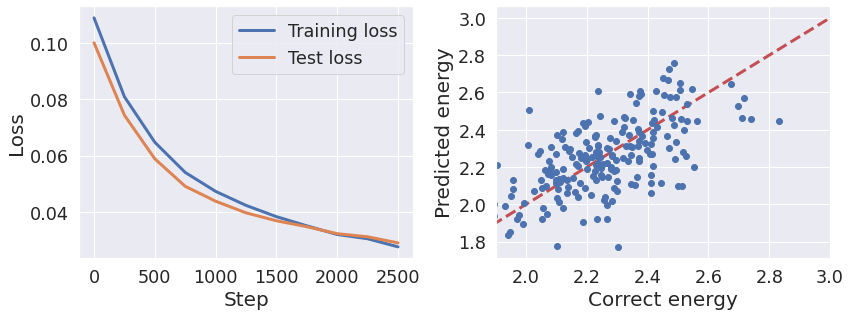

In [31]:
plt.subplot(1, 2, 1)

out_steps = [x * print_every for x in range(len(train_losses))]
plt.plot(out_steps, train_losses, linewidth=3, label='Training loss')
plt.plot(out_steps, test_losses, linewidth=3, label='Test loss')
plt.legend(loc='upper right')
format_plot('Step', 'Loss')

plt.subplot(1, 2, 2)


plt.plot(np.arange(1.8, 3.1, 0.1), np.arange(1.8, 3.1, 0.1), 'r--', linewidth=3)
plt.plot(test_energies, vmap(neural_energy_fn)(test_positions), 'o')
plt.xlabel('Correct energy', fontsize=20)
plt.ylabel('Predicted energy', fontsize=20)

plt.xlim([1.9, 3.0])

finalize_plot((2, 0.75))


Next, let's see how the predicted forces on each particle compares to the correct force. Note that $F_i = -\frac{dU(x)}{dx_i}$, where $U$ is the potential energy given by our neural network, and $x_i$ are the spatial coordinates of particles. $U(x) = NN(G(x))$, where $NN$ is the neural network and $G(x)$ is the symmetry functions. Thus 
$$F_i = -\frac{dNN(G(x))}{dG(x)}\frac{dG(x)}{dx}.$$
$\frac{dNN(G(x))}{dG(x)}$ is easy to get in most neural network packages, but $\frac{dG(x)}{dx}$ is often a pain point and has to be coded up by hand. In JAX, MD, we get $\frac{dG(x)}{dx}$ for free without any extra work. To demonstrate this we will compare the forces computed by the neural network with the true forces. We will measure by computing the cosine-similarity between the two forces, $\cos\theta$.

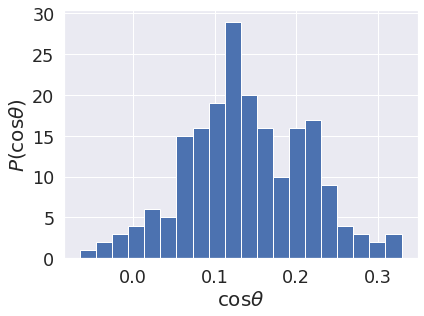

In [32]:
@jit
@vmap
def angle(r):
  a = grad(neural_energy_fn)(r)
  b = grad(energy_fn)(r)
  return np.sum(np.multiply(a, b)/np.linalg.norm(a)/np.linalg.norm(b))

angles = angle(test_positions)
plt.hist(angles, bins = 20)
plt.xlabel('Inner product between ML force and correct force', fontsize=20)
format_plot('$\\cos\\theta$', '$P(\\cos\\theta)$')
finalize_plot((1, 0.75))

We see that while the neural network has begun to learn the correct force, there is still room to improve the results. You can get better results by increasing `train_steps` above.

## Optimization Through Dynamics

So far we have demonstrated how JAX MD can make common workloads easier. However, combining molecular dynamics with automatic differentiation opens the door for qualitatively new research. One such avenue involves differentiating through the simulation trajectory to optimize physical parameters. There have been several excellent applications so far in e.g. [protein folding](https://openreview.net/forum?id=Byg3y3C9Km), but until now this has involved significant amounts of specialized code. This vein of research is also similar to recent work in machine learning on [meta-optimization.](https://arxiv.org/abs/1606.04474) 

Here we revisit the bubble raft example above. We will show how one can control the structure of the bubble raft by differentiating through the simulation. As we saw, bubble rafts form a hexagonal structure when all of the bubbles have the same size. However, when the bubbles have different sizes the situation can change considerably. To experiment with these changes, we're going to set up a simulation of a bubble raft with bubbles of two distinct sizes. To keep things simple, we'll let half of the bubbles have diameter $1$ and half have diameter $D$. 

To control the conditions of the experiment, we will keep the total volume of the bubbles constant. To do this, note that if there are $N$ bubbles then the total volume of water filled by bubbles is,
$$V_{\text{bubbles}} = \frac N8\pi(D^2 + 1)$$
where the factor of $8$ comes from the fact that our system is split into two halves and we are using diameters not radii. Since the volume of our simulation is $V = L^2$ if we want to keep the "packing fraction", $\phi = V_{\text{bubbles}} / V$ constant then we will have to scale the size of the box to be,
$$L = \sqrt{\frac{V_{\text{bubbles}}}{\phi}}.$$
We begin by setting up some experiment parameters and writing a function to compute $L$ as a function of $D$.

In [33]:
N = 128
N_2 = N // 2

simulation_steps = np.arange(300)
dt = 1e-2
temperature = 1e-5

key = random.PRNGKey(0)

packing_fraction = 0.98
markersize = 260

def box_size_at_packing_fraction(diameter):
  bubble_volume = N_2 * np.pi * (diameter ** 2 + 1) / 4
  return np.sqrt(bubble_volume / packing_fraction)

Now we write a simulation similar to the one in the Automatic Ensembling section. This time, however, will take a `diameter` in addition to a key. Additionally, unlike in the previous simulations where we only had one kind of bubble, this time we will have two. This is implemented here using the notion of bubble "species". We will split our bubble raft into two different species of bubbles that we will label $A$ and $B$ respectively. By having two different "species" of bubbles we can define different values of $\sigma$ for interactions between the different species. Since we have two different species this gives us three different $\sigma$ to define: $\sigma_{AA}$, $\sigma_{AB}$, and $\sigma_{BB}$. We know that $\sigma_{AA} = D$ and $\sigma_{BB} = 1$, but what should $\sigma_{AB}$ be? Since the $\sigma$ denote radii, it should be the case that $\sigma_{AB} = \frac12(D + 1)$. We can setup a helper function to setup the species now. 

In [34]:
species = np.array([0] * (N_2) + [1] * (N_2), dtype=np.int32)

def species_sigma(diameter):
  d_AA = diameter
  d_BB = 1
  d_AB = 0.5 * (diameter + 1)
  return np.array(
      [[d_AA, d_AB], 
       [d_AB, d_BB]]
  )

We will feed the `species` and `sigma` definitions into the `energy.soft_sphere_pair` function. We will also have our simulation return three things: the box size, the final energy, and the final positions. Unlike the previous simulations, we will minimize the energy of the system instead of simulating using brownian motion. To do this we will use the minimizer, `init_fun, apply_fun = minimize.fire_descent(energy_fun, shift_fun)` provided by JAX MD. 

In [35]:
from jax_md import minimize

def simulation(diameter, key):
  box_size = box_size_at_packing_fraction(diameter)
  displacement, shift = space.periodic(box_size)

  sigma = species_sigma(diameter)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = minimize.fire_descent(energy_fn, shift)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, simulation_steps)

  return box_size, energy_fn(state.position), state.position

Now let's run simulations with two different values of $D$ and draw them side-by-side. In one case we will use $D = 1$ so that both species are the same and this will result in the same hexagonal configuration as in the warm up. However, we will then run a simulation with $D = 0.8$ to see what happens when all the bubbles don't have the same size.

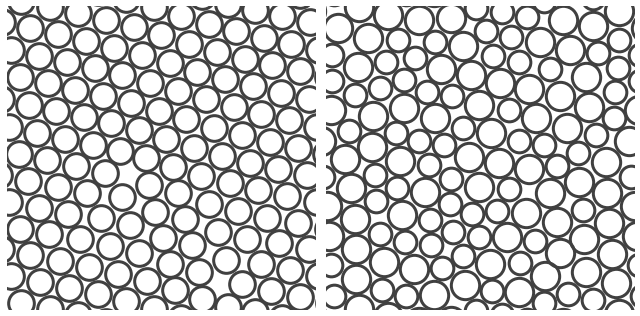

In [36]:
plt.subplot(1, 2, 1)

box_size, raft_energy, bubble_positions = simulation(1.0, key)
draw_system(bubble_positions, box_size, markersize)
finalize_plot((0.5, 0.5))

plt.subplot(1, 2, 2)

box_size, raft_energy, bubble_positions = simulation(0.8, key)
draw_system(bubble_positions[:N_2], box_size, 0.8 * markersize)
draw_system(bubble_positions[N_2:], box_size, markersize)
finalize_plot((2.0, 1))

The hexagonal structure when the bubbles have the same size has broken down in the two-species case. To get a bit more insight into this we will use the automatic vectorization capabilities to see how the structure and energy of bubble rafts depends on `diameter`.

In [37]:
ensemble_size = 40

# Vectorize over both random keys and diameter.
vec_simulation = vmap(vmap(simulation, (None, 0)), (0, None))

sim_keys = random.split(key, ensemble_size)
diameter = np.linspace(0.4, 1.0, 10)

box_size, raft_energy, bubble_positions = vec_simulation(diameter, sim_keys)

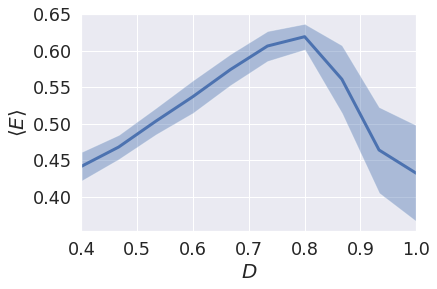

In [38]:
E_mean = np.mean(raft_energy, axis=1)
E_std = np.std(raft_energy, axis=1)

plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

At small values of the diameter, the energy is low and increases with increasing diameter until a maximum in the energy at which point it drops precipitously. We can visualize an example system at each of these diameter disparities to see what is happening. We will color the bubble rafts by their energy.

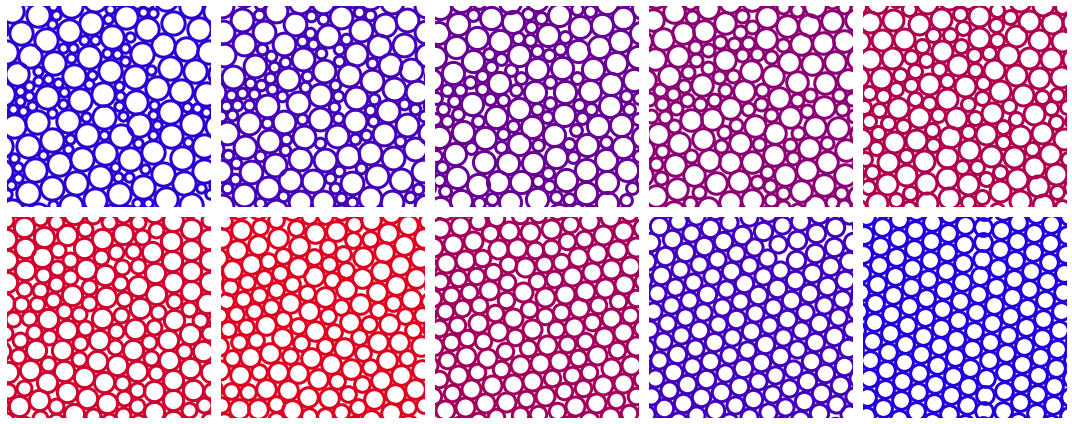

In [39]:
ms = 180
for i, d in enumerate(diameter):
  # if i % 2:
  #   continue
  plt.subplot(2, 5, i + 1)
  c = min(1, max(0, (E_mean[i] - 0.4) * 4))
  color = [c, 0, 1 - c] 
  draw_system(bubble_positions[i, 0, :N_2], box_size[i, 0], d * ms, color=color)
  draw_system(bubble_positions[i, 0, N_2:], box_size[i, 0], ms, color=color)

finalize_plot((2.5, 1))

Notice that when the diameter of the smaller bubbles is very smaller-than or equal-to that of the larger ones, the structure looks much more hexagonal. However, when the diameter is in-between (where the energy is high) the bubbles end up looking like they are arranged randomly. This is an effect known as the [Jamming transition.](https://) However, could we have found this optimally disordered region without brute force? Let's try to maximize the energy with respect to the diameter, $D$, directly. 

To do this, we will run short simulation trajectories starting with the positions after minimization that we found above. At the end of the short simulation we will compute the energy of the bubble raft. We will then take the derivative of the energy after the short simulation with respect to the particle diameter.  We're going to make use of the JAX's `grad` function. The function `df_dx = grad(f)` takes a function and returns a new function that computes its gradient with respect to its first argument. Let's now write a shorter simulation function and have it just return the final energy of the system.

In [40]:
short_simulation_steps = np.arange(10)
def short_simulation(diameter, positions, key):
  box_size = box_size_at_packing_fraction(diameter)
  R = positions / box_size
  displacement, shift = space.periodic_general(box_size * np.eye(2))

  sigma = species_sigma(diameter)
  energy_fn = energy.soft_sphere_pair(
      displacement, species=species, sigma=sigma)

  init_fn, apply_fn = minimize.gradient_descent(energy_fn, shift, 1e-3)
  state = init_fn(R)

  do_step = lambda state, t: (apply_fn(state, t=t), ())
  state, _ = lax.scan(do_step, state, short_simulation_steps)

  return energy_fn(state)

Next, let's take the derivative of the energy with respect to the particle diameters and vectorize it over the ensemble of initial positions.


In [41]:
dE_dD_fun = grad(short_simulation)
dE_dD_fun = jit(vmap(dE_dD_fun, (None, 0, 0)))

Now, we run the simulation for each diameter and record the gradients over each member of the ensemble. We then plot the average gradient against diameter and compare it with the energy that we found by directly simulating the bubble raft.

In [42]:
dE_dD = []
for i, d in ProgressIter(enumerate(diameter), len(diameter)):
  key, split = random.split(key)
  split = random.split(split, ensemble_size)
  dE_dD += [dE_dD_fun(d, bubble_positions[i], split)]
dE_dD = np.array(dE_dD)

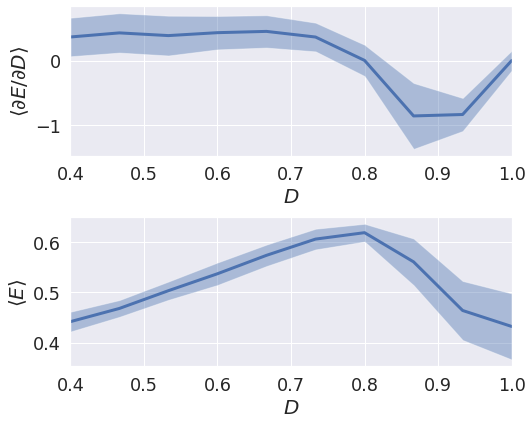

In [43]:
plt.subplot(2, 1, 1)

dE_mean = np.mean(dE_dD, axis=1)
dE_std = np.std(dE_dD, axis=1)

plt.plot(diameter, dE_mean, linewidth=3)
plt.fill_between(diameter, dE_mean + dE_std, dE_mean - dE_std, alpha=0.4)

plt.xlim([0.4, 1.0])
format_plot('$D$', '$\\langle \\partial E/\\partial D\\rangle$')

plt.subplot(2, 1, 2)
plt.plot(diameter, E_mean, linewidth=3)
plt.fill_between(diameter, E_mean + E_std, E_mean - E_std, alpha=0.4)

plt.xlim([0.4, 1.0])

format_plot('$D$', '$\\langle E\\rangle$')

finalize_plot((1.25, 1))

We see that the gradient is positive and constant for $D < 0.8$ corresponding to the linear increase in the average energy. Moreover, we see that the derivative crosses zero exactly at the maximum average energy. Finally, we observe that the gradient goes back to zero at $D = 1$. This suggests that $D = 0.8$ is the point of maximum disorder, as we found by brute force above. It also shows that $D = 1$ is the minimum energy configuration of the diameter. Although we hadn't hypothesized it, we realize this must be true since $D < 1$ states are symmetric with $D > 1$ as we keep the total packing fraction constant.